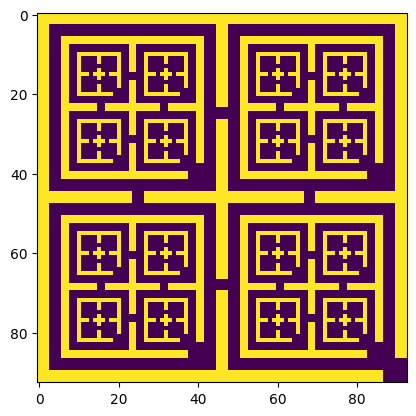

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import hypll
from hypll.manifolds.poincare_ball import Curvature, PoincareBall
from hypll.optim import RiemannianAdam
import hypll.nn as hnn
from hypll.tensors import TangentTensor
from matplotlib.animation import FuncAnimation
import argparse
from pyramid import create_pyramid
from continuous_maze import bfs, gen_traj, plot_traj, ContinuousGridEnvironment, TrajectoryDataset, LabelDataset
from hyperbolic_networks import HyperbolicMLP, hyperbolic_infoNCE_loss, manifold_map
from networks import StateActionEncoder, StateEncoder, infoNCE_loss
from train import get_maze
import os

In [2]:
hyperbolic = False
maze_type = 'slit'
maze = get_maze(maze_type)

epochs = 16

e1_path = f'/home/yongweic/hyperbolic/models/experiment_hyperbolic_{hyperbolic}_epochs_{epochs}_trajectories_10000_maze_{maze_type}_embeddingdim_2_encoder1_epoch_{epochs}.pth'
e2_path = f'/home/yongweic/hyperbolic/models/experiment_hyperbolic_{hyperbolic}_epochs_{epochs}_trajectories_10000_maze_{maze_type}_embeddingdim_2_encoder2_epoch_{epochs}.pth'




device = "cuda" if torch.cuda.is_available() else "cpu"

manifold = PoincareBall(c=Curvature(value=0.1, requires_grad=True))

if hyperbolic:
    encoder1 = HyperbolicMLP(in_features=4, out_features=2, manifold=manifold.to(device)).to(device)
    encoder2 = HyperbolicMLP(in_features=2, out_features=2, manifold=manifold.to(device)).to(device)
    optimizer = RiemannianAdam(list(encoder1.parameters()) + list(encoder2.parameters()), lr=0.001)
else:
    encoder1 = StateActionEncoder(2).to(device)
    encoder2 = StateEncoder(2).to(device)
    optimizer = optim.Adam(list(encoder1.parameters()) + list(encoder2.parameters()), lr=0.001)

encoder1.load_state_dict(torch.load(e1_path))
encoder2.load_state_dict(torch.load(e2_path))

slit maze


<All keys matched successfully>

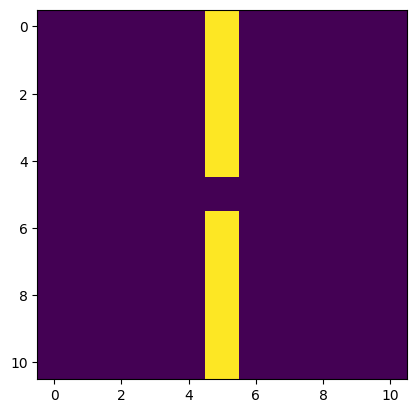

In [3]:
plt.imshow(maze)

In [4]:
valid_indices = np.argwhere(maze == 0)
valid_indices = valid_indices + 0.5

valid_indices

array([[ 0.5,  0.5],
       [ 0.5,  1.5],
       [ 0.5,  2.5],
       [ 0.5,  3.5],
       [ 0.5,  4.5],
       [ 0.5,  6.5],
       [ 0.5,  7.5],
       [ 0.5,  8.5],
       [ 0.5,  9.5],
       [ 0.5, 10.5],
       [ 1.5,  0.5],
       [ 1.5,  1.5],
       [ 1.5,  2.5],
       [ 1.5,  3.5],
       [ 1.5,  4.5],
       [ 1.5,  6.5],
       [ 1.5,  7.5],
       [ 1.5,  8.5],
       [ 1.5,  9.5],
       [ 1.5, 10.5],
       [ 2.5,  0.5],
       [ 2.5,  1.5],
       [ 2.5,  2.5],
       [ 2.5,  3.5],
       [ 2.5,  4.5],
       [ 2.5,  6.5],
       [ 2.5,  7.5],
       [ 2.5,  8.5],
       [ 2.5,  9.5],
       [ 2.5, 10.5],
       [ 3.5,  0.5],
       [ 3.5,  1.5],
       [ 3.5,  2.5],
       [ 3.5,  3.5],
       [ 3.5,  4.5],
       [ 3.5,  6.5],
       [ 3.5,  7.5],
       [ 3.5,  8.5],
       [ 3.5,  9.5],
       [ 3.5, 10.5],
       [ 4.5,  0.5],
       [ 4.5,  1.5],
       [ 4.5,  2.5],
       [ 4.5,  3.5],
       [ 4.5,  4.5],
       [ 4.5,  6.5],
       [ 4.5,  7.5],
       [ 4.5,

/tmp/ipykernel_2321298/150007491.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  points = torch.tensor(points)


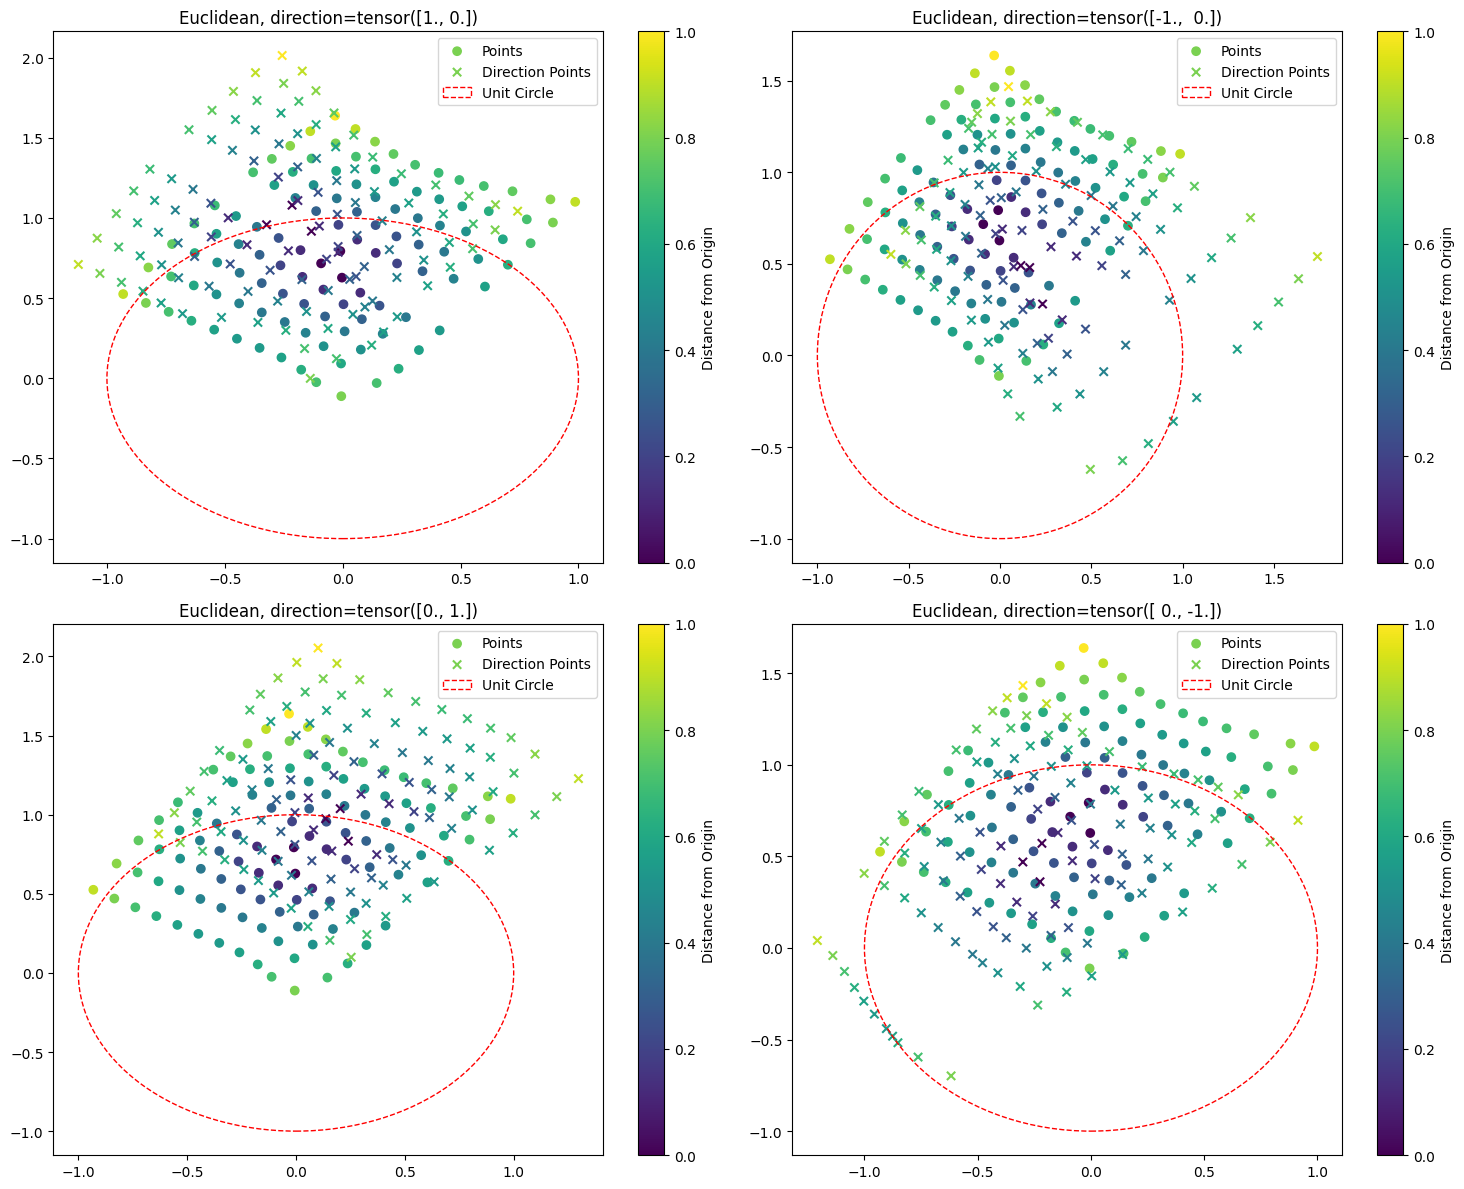

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches

def plot(ax, maze, direction, encoder1, encoder2, manifold, hyperbolic, device):
    with torch.no_grad():
        points = []

        valid_indices = np.argwhere(maze == 0)
        valid_indices = valid_indices + 0.5
        grid = valid_indices
        
        for p in grid:
            v = torch.tensor(p).to(device, torch.float32)
            v = encoder2(v)
            if hyperbolic:
                v = manifold.project(v)
                v = v.tensor
            points.append(v.cpu().detach().numpy())

        dir_points = []
        for p in grid:
            v = torch.stack([torch.tensor(p), direction]).flatten().to(device, torch.float32)
            v = encoder1(v)
            if hyperbolic:
                v = manifold.project(v)
                v = v.tensor
            dir_points.append(v.cpu().detach().numpy())

    points = torch.tensor(points)
    dir_points = torch.tensor(dir_points)

    # Compute distances from origin
    distances_points = torch.norm(torch.tensor(grid) - torch.tensor([5., 5.]), dim=1).numpy()
    distances_dir_points = torch.norm(torch.tensor(grid) - torch.tensor([5., 5.]), dim=1).numpy()

    # Normalize distances for colormap
    norm_distances_points = (distances_points - distances_points.min()) / (distances_points.max() - distances_points.min())
    norm_distances_dir_points = (distances_dir_points - distances_dir_points.min()) / (distances_dir_points.max() - distances_dir_points.min())

    # Use a colormap
    cmap = cm.viridis

    # Create scatter plots with colors based on distance
    scatter1 = ax.scatter(x=points[:,0], y=points[:,1], c=norm_distances_points, cmap=cmap, label='Points')
    scatter2 = ax.scatter(x=dir_points[:,0], y=dir_points[:,1], c=norm_distances_dir_points, cmap=cmap, marker='x', label='Direction Points')

    # Add color bar for the first scatter plot
    if ax.get_legend() is None:
        plt.colorbar(scatter1, ax=ax, label='Distance from Origin')

    # Add unit circle
    unit_circle = patches.Circle((0, 0), radius=1, edgecolor='red', facecolor='none', linestyle='--', label='Unit Circle')
    ax.add_patch(unit_circle)

    if hyperbolic:
        ax.set_title(f'Hyperbolic, direction={direction}')
    else:
        ax.set_title(f'Euclidean, direction={direction}')
    ax.legend()

# Create a figure and a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Example usage
directions = [torch.tensor([1., 0.]), torch.tensor([-1., 0.]), torch.tensor([0., 1.]), torch.tensor([0., -1.])]
ax_flat = axs.flatten()  # Flatten the 2x2 array of axes for easy iteration

for i, direction in enumerate(directions):
    plot(ax_flat[i], maze, direction, encoder1, encoder2, manifold, hyperbolic, device)

plt.tight_layout()
plt.show()


In [6]:
def visualize_path(start, end, encoder_mod1, encoder_mod2, hyperbolic=False, manifold=None, max_steps=100, eps=50):
    with torch.no_grad():
        # maze.cpu()
        vec2 = None
        start = torch.tensor(start).to(device, torch.float32)
        goal = torch.tensor(end).to(device, torch.float32)
        
        vec2 = encoder_mod2(goal)

        env = ContinuousGridEnvironment(maze, start.cpu(), {})
        fig, ax = plt.subplots()

        def update(i):
            with torch.no_grad():
                cur_pos = env.agent_position

                activations = []
                angles = torch.linspace(0., 2 * torch.pi, 16)
                for a in angles:
                    action = torch.tensor([torch.sin(a), torch.cos(a)])
                    vec1 = torch.tensor([cur_pos[0], cur_pos[1], torch.sin(a), torch.cos(a)]).to(device, torch.float32)
                    vec1 = encoder_mod1(vec1)

                    # MANIFOLD EVAL
                    if hyperbolic:
                        activations.append((action, -manifold.dist(x=vec1, y=vec2)))
                    else:
                        activations.append((action, -torch.norm(vec1 - vec2)))

                best_action = activations[np.argmax([x[1].cpu() for x in activations])][0]
                angle = np.arctan2(best_action[0], best_action[1]) + np.random.normal() * eps * (2 * np.pi / 360)
                best_action = torch.tensor(np.array([np.sin(angle), np.cos(angle)]))
                env.move_agent(best_action)
                # print(f'agent position: {env.agent_position}')
                ax.clear()
                env.display(ax=ax)

        # Set animation display in Jupyter notebook and figure resolution
        plt.rcParams["animation.html"] = "jshtml"
        plt.rcParams['figure.dpi'] = 150

        # Create the animation
        ani = FuncAnimation(fig, update, frames=max_steps, interval=max_steps, repeat=False)

    return ani

/tmp/ipykernel_2321298/3839252379.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  start = torch.tensor(start).to(device, torch.float32)
/tmp/ipykernel_2321298/3839252379.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  goal = torch.tensor(end).to(device, torch.float32)


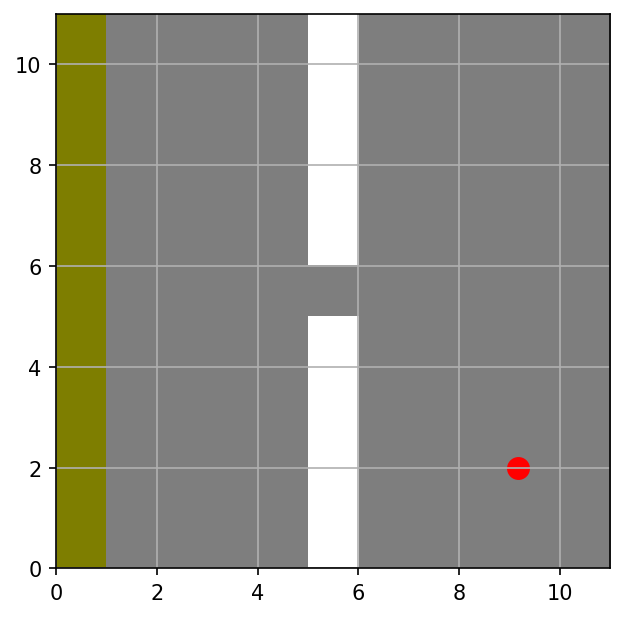

In [8]:
start = torch.tensor([0., 0.])
end = torch.tensor([10., 10.])


visualize_path(start, end, encoder1, encoder2, hyperbolic=False, manifold=manifold)

/tmp/ipykernel_2321298/3839252379.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  start = torch.tensor(start).to(device, torch.float32)
/tmp/ipykernel_2321298/3839252379.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  goal = torch.tensor(end).to(device, torch.float32)


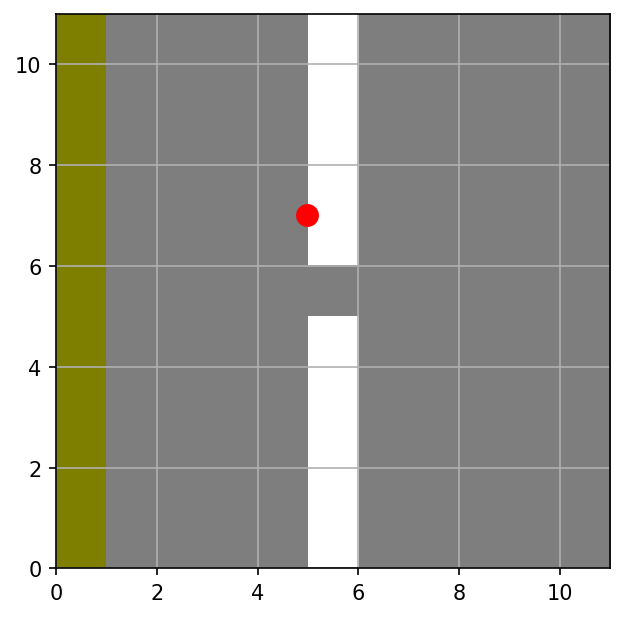

In [10]:
start = torch.tensor([5., 2.])
end = torch.tensor([2., 10.])


visualize_path(start, end, encoder1, encoder2, hyperbolic=False, manifold=manifold)